In [1]:
! pip install -U google-cloud
! pip install -U google-cloud-storage
! pip install -U requests  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.1/107.1 KB 15.0 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-core
    Found existing installation: google-cloud-core 2.2.3
    Uninstalling google-cloud-core-2.2.3:
      Successfully uninstalled google-cloud-core-2.2.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.2.1
    Uninstalling google-cloud-storage-2.2.1:
      Successfully uninstalled google-cloud-storage-2.2.1


In [2]:
from google.cloud import storage
from google.oauth2 import service_account
import os

In [3]:
!gsutil ls gs://cs6384-bucket/

gs://cs6384-bucket/asus_rog/
gs://cs6384-bucket/info/
gs://cs6384-bucket/oneplus/
gs://cs6384-bucket/sample_result/
gs://cs6384-bucket/test/
gs://cs6384-bucket/test_upload/
gs://cs6384-bucket/train/


In [4]:
# |test| = 23819
!gsutil du gs://cs6384-bucket/test | wc -l

23819


In [5]:
# |train} = 79435
!gsutil du gs://cs6384-bucket/train | wc -l

79435


In [6]:
!gsutil du gs://cs6384-bucket/info/ | wc -l

3


In [7]:
!gsutil du gs://cs6384-bucket/sample_result | wc -l

4


In [8]:
!mkdir /home/jupyter/MOUNT_DIRECTORY

In [9]:
!gcsfuse --implicit-dirs cs6384-bucket /home/jupyter/MOUNT_DIRECTORY

2022/05/04 21:51:49.677531 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount point: /home/jupyter/MOUNT_DIRECTORY
2022/05/04 21:51:49.690193 Opening GCS connection...
2022/05/04 21:51:50.047115 Mounting file system "cs6384-bucket"...
2022/05/04 21:51:50.051861 File system has been successfully mounted.


In [12]:
!ls /home/jupyter/MOUNT_DIRECTORY/test | wc -l

23817


In [13]:
!pip install opencv-python
!pip install torch torchvision torchaudio torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 21.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 81.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 110.7 MB/s eta 0:00:00


In [33]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision.transforms as T
from tqdm import tqdm
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass

In [34]:
METADATA_PATH = '/home/jupyter/MOUNT_DIRECTORY/info'
TRAIN_PATH = '/home/jupyter/MOUNT_DIRECTORY/train'
TEST_PATH = '/home/jupyter/MOUNT_DIRECTORY/test'

artdf = pd.read_csv(os.path.join(METADATA_PATH, 'all_data_info.csv'))

In [35]:
# Filter only artists with more than 300 paintings and balance them out

datadf = artdf.groupby("artist").filter(lambda x: len(x) >= 300)
g = datadf.groupby('artist')
datadf = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
datadf = datadf.drop(columns=['date'])
len(datadf)

# |dataset| = 17214

17214

In [36]:
# Convert artist names into label indexes
artist = datadf[['new_filename','artist','in_train']]
artist['artist'] = artist['artist'].astype('category')
artist['artist_idx'] = artist['artist'].cat.codes
artist.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


new_filename            artist  in_train  artist_idx
artist                                                                 
Albert Bierstadt 0    71666.jpg  Albert Bierstadt      True           0
                 1    86453.jpg  Albert Bierstadt     False           0
                 2    14173.jpg  Albert Bierstadt      True           0
                 3    15405.jpg  Albert Bierstadt     False           0
                 4    99268.jpg  Albert Bierstadt      True           0

In [37]:
artist['in_train'].value_counts()

True     13216
False     3998
Name: in_train, dtype: int64

In [38]:
# Split into train and test sets
train_df = artist[artist['in_train'] == True]
test_df = artist[artist['in_train'] == False]
print(len(train_df))
print(len(test_df))

13216
3998


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
print(torch.cuda.is_available())

True


In [22]:
class ImageProcessor(Dataset):

    def __init__(self, path, metadata_df, mode = 'RGB', is_train = True, crop_width = 224, crop_height = 224):
        self.path = path
        self.mode = mode
        self.metadata_df = metadata_df
        self.X,self.y = self.read_input(self.path)
        self.is_train = is_train
        self.crop_width = crop_width
        self.crop_height = crop_height
        self.transforms = None
        if self.is_train:
            self.transforms = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.RandomCrop(224), T.RandomHorizontalFlip()])
        else:
            self.transforms = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.CenterCrop(224)])
        

    # A simple function to get the file paths of all the training images and their corresponding labels
    def read_input(self,path):

        if os.path.isfile(path):
            _, filename = os.path.split(path)
            label = self.metadata_df[self.metadata_df['new_filename'] == filename, 'artist_idx'].iloc[0]
            return [path],[label]

        elif os.path.isdir(path):
            paths = []
            labels = []
            for i, df in self.metadata_df.iterrows():
                image = df['new_filename']
                img_path = os.path.join(path,image)
                label = df['artist_idx']
                paths.append(img_path)
                labels.append(label)
            return paths,labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):

        # Fetch image path and label
        path = self.X[idx]
        label = self.y[idx]

        img = cv2.imread(path)

        # Convert to BGR if necessary
        if self.mode == 'BGR':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        # Preprocess image
        crop = self.transforms(img)
        
        return crop.to(device), torch.Tensor([int(label)]).to(device)

In [23]:
# Check for missing images
# Run only once
from tqdm import tqdm
not_exists = []
path = TRAIN_PATH
for i, df in tqdm(train_df.iterrows()):
    image = df['new_filename']
    img_path = os.path.join(path,image)
    img = cv2.imread(img_path)
    if img is None:
        not_exists.append(img_path)
        
not_exists

125it [02:11,  1.05s/it][ WARN:0@174.672] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/jupyter/MOUNT_DIRECTORY/train/22811.jpg'): can't open/read file: check file path/integrity



KeyboardInterrupt: 

In [24]:
# Delete '/home/jupyter/MOUNT_DIRECTORY/train/84772.jpg' from df since it does not exist
print(len(train_df))
train_df = train_df[train_df['new_filename'] != '84772.jpg']
print(len(train_df))

13213
13212


In [29]:
# Create train and test dataset processors
train_dataset = ImageProcessor(TRAIN_PATH,train_df)
test_dataset = ImageProcessor(TEST_PATH,test_df,is_train = False)
print(len(train_dataset))
print(len(test_dataset))

13212
4001


In [30]:
# Create train and test Dataloaders
BATCH_SIZE = 128

# train_loader = DataLoader(train_dataset,  batch_size = BATCH_SIZE, shuffle = True, num_workers = os.cpu_count())
# test_loader = DataLoader(test_dataset,  batch_size = BATCH_SIZE, shuffle = True, num_workers = os.cpu_count())

train_loader = DataLoader(train_dataset,  batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset,  batch_size = BATCH_SIZE, shuffle = True)

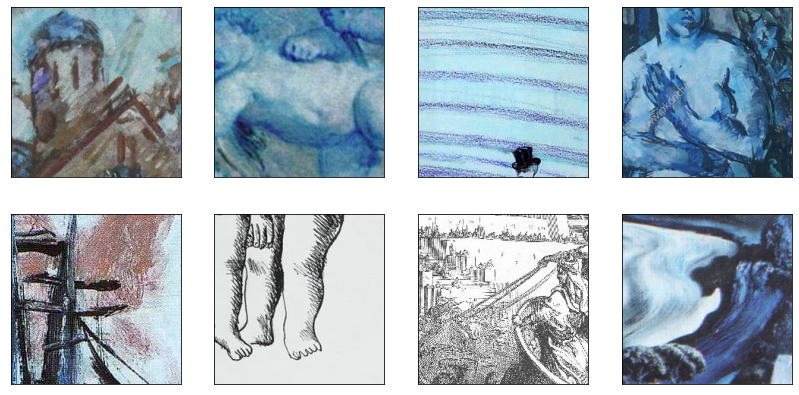

In [41]:
for batch_idx, data in enumerate(train_loader):
    fig = plt.figure(figsize = (14, 7))
    imgs,labels = data
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(imgs[i].cpu().permute(1, 2, 0))
    break

In [50]:
# Our Baseline Convolutional Neural Network
class BaselineConvnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
        nn.init.zeros_(self.conv1.bias) 
        nn.init.normal_(self.conv1.weight, mean = 0, std = (math.sqrt(2/(32*3*3))))
        
        self.pool = nn.MaxPool2d(2)
        self.batch_norm2d = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 3, stride = 2, padding = 1)
        nn.init.zeros_(self.conv2.bias) 
        nn.init.normal_(self.conv2.weight, mean = 0, std = (math.sqrt(2/(32*3*3))))
        
        self.batch_norm1d = nn.BatchNorm1d(228)
        self.fc1 = nn.Linear(6272, 228)
        self.fc2 = nn.Linear(228, 57)

    def forward(self, x):
        
        # Convolution stack 1
        x = self.conv1(x)
        x = self.batch_norm2d(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Convolution stack 2
        x = self.conv2(x)
        x = self.batch_norm2d(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten and FC layers
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.batch_norm1d(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
    

In [51]:
model = BaselineConvnet()
model = model.float()
model = model.to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
         MaxPool2d-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Linear-7                  [-1, 228]       1,430,244
       BatchNorm1d-8                  [-1, 228]             456
            Linear-9                   [-1, 57]          13,053
Total params: 1,454,025
Trainable params: 1,454,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.33
Params size (MB): 5.55
Estimated Total Size (MB): 13.45
--------------------------------------

In [56]:
def train(model,train_loader,epochs = 2, lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, k = 3):
    
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr, betas = (beta_1,beta_2))
    
    epoch_losses = []
    epoch_accuracies = []
    
    for e in range(epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        correct = 0.0
        total_size = 0
        acc = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float().to(device))
            
            loss = loss_fn(outputs, labels.squeeze().type(torch.LongTensor).to(device))
            loss.backward()
            optimizer.step()
            
            batch_size = inputs.size(0)
                      
            predicted = torch.topk(outputs,1,1).indices
            correct += (predicted == labels).sum().item()
            total_size += 1
            
            # print statistics
            batch_size = inputs.size()[0]
            running_loss += loss.item()
            print(f'[{e + 1}, {i * batch_size:5d}] batch_loss: {loss.item():.3f}')
        
        epoch_loss = (running_loss/total_size)
        acc = (correct/len(train_dataset)) * 100
        
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_loss)
        print(f'[Epoch {e + 1}: epoch_loss: {epoch_loss:.3f} accuracy: {acc:.3f}]')

    print('Finished Training')
    return epoch_losses, epoch_accuracies

In [ ]:
ep_loss, ep_acc = train(model,train_loader,epochs = 15)

[1,     0] batch_loss: 4.124
[1,   128] batch_loss: 3.943
[1,   256] batch_loss: 3.939
[1,   384] batch_loss: 3.898
[1,   512] batch_loss: 3.755
[1,   640] batch_loss: 3.868
[1,   768] batch_loss: 3.885
[1,   896] batch_loss: 3.863
[1,  1024] batch_loss: 3.786
[1,  1152] batch_loss: 3.906
[1,  1280] batch_loss: 3.779
[1,  1408] batch_loss: 3.872
[1,  1536] batch_loss: 3.741
[1,  1664] batch_loss: 3.791
[1,  1792] batch_loss: 3.763
[1,  1920] batch_loss: 3.870
[1,  2048] batch_loss: 3.754


In [ ]:
!ls /home/jupyter/MOUNT_DIRECTORY/

In [46]:
MODEL_PATH = './baseCNN1.pth'
torch.save(model.state_dict(),MODEL_PATH)

In [47]:
model = BaselineConvnet()
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [48]:
ep_loss2, ep_acc2 = train(model,train_loader,epochs = 5)

KeyboardInterrupt: 

In [ ]:
print(datadf['pixelsx'].max())
print(datadf['pixelsy'].max())

In [ ]:
img = cv2.imread()